In [1]:
#IPython extension to reload modules before executing user code. If we make any change in function 
# and imoprting it we don't need to restart if we use auto reload 
%load_ext autoreload

# to print in between values as well without print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [30]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import json


# sklearn libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import classification_report
from pprint import pprint as pp


# scipy
from scipy.stats import boxcox

# yellowbrick
from yellowbrick.classifier import ROCAUC

# Supporting Functions

In [2]:
# to save pickle file
def save_pkl_model(path,model):
    pickle.dump(model, open(path,'wb'))

In [3]:
# to load
def load_pkl_model(path):
    sc = pickle.load(open(path,'rb'))
    return sc

In [4]:
def preprocess_pipeline_1(test):
   
    # miss_num_imputer = load_pkl_model(missing_num_imputer_path)
    # missing_cat_imputer = load_pkl_model(missing_cat_imputer_path)
    ohe_converter = load_pkl_model(ohe_converter_path)
    num_transformer = load_pkl_model(mms_converter_path)

    # processing numeric
    num_cols = test.select_dtypes(include='number')
    num_column_names = num_cols.columns
    # num_miss_processed = miss_num_imputer.transform(num_cols)
    num_scalled = num_transformer.transform(num_cols)
    num_scalled_df = pd.DataFrame(num_scalled,columns=num_column_names)


    # processing categoric
    cat_cols = test.select_dtypes(include='O')
    # cat_miss_processed = missing_cat_imputer.transform(cat_cols)
    cat_encoded = ohe_converter.transform(cat_cols).toarray()
    cat_encoded_df = pd.DataFrame(cat_encoded,columns=ohe_converter.get_feature_names_out())


    # combine categoric and numeric data and return
    test_processed = pd.concat([num_scalled_df,cat_encoded_df],axis=1)
    
    return test_processed

In [5]:
def func_dropCol(df):
    for i in column_elimination:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
    return df

# Test and Analysis

## Load and Predict

In [42]:
# spacify saved preprocessing model paths
# missing_num_imputer_path = 'Data/processing_models/imputer_num.pkl'
# missing_cat_imputer_path = 'Data/processing_models/imputer_cat.pkl'
ohe_converter_path = 'Data/processing_models/ohe_converter.pkl'
mms_converter_path = 'Data/processing_models/mms_converter.pkl'
column_elimination = ['SectionID',
                   'StageID',
                  'Semester']
# # Specify final ML model path
# final_model_path = 'models/random_forest.pkl'


In [7]:
# load test data and check
test_data = pd.read_csv('Data/test.csv')
test_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Jordan,lowerlevel,G-02,A,French,S,Mum,25,80,29,23,No,Good,Under-7,M
1,M,KW,KuwaIT,MiddleSchool,G-07,A,Math,F,Father,11,2,2,8,No,Bad,Under-7,L
2,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,50,7,9,50,Yes,Bad,Above-7,M
3,M,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Father,10,8,10,10,Yes,Bad,Above-7,M
4,M,Iraq,Iraq,MiddleSchool,G-06,A,English,F,Mum,74,71,56,37,No,Good,Under-7,H


In [9]:
# devide Xtest ytest to compare
X_test,y_test = test_data.loc[:,~test_data.columns.isin(['Class'])],test_data['Class']

In [10]:
# preporcess the data for the model input
X_test_processed = preprocess_pipeline_1(X_test)
X_test_processed.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.25,0.808081,0.295918,0.224490,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,0.11,0.020202,0.020408,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.070707,0.091837,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.10,0.080808,0.102041,0.091837,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.74,0.717172,0.571429,0.367347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [13]:
# drop features not used
X_test_processed = func_dropCol(X_test_processed)
X_test_processed

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_History,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.25,0.808081,0.295918,0.224490,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.11,0.020202,0.020408,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.070707,0.091837,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.10,0.080808,0.102041,0.091837,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.74,0.717172,0.571429,0.367347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.55,0.727273,0.846939,0.132653,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
68,0.00,0.030303,0.102041,0.020408,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.70,0.696970,0.357143,0.295918,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
70,0.05,0.090909,0.193878,0.989796,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# load the json to convert from num to lable
with open('Data/processing_models/num_to_label.json') as json_file:
    num_to_label = json.load(json_file)

with open('Data/processing_models/label_to_num.json') as json_file:
    label_to_num = json.load(json_file)

num_to_label,label_to_num

({'0': 'H', '1': 'L', '2': 'M'}, {'H': 0, 'L': 1, 'M': 2})

In [46]:
def predict(final_model,num_to_label,X_test_processed):
   
    
    # prefict the model
    y_pred = final_model.predict(X_test_processed)
    y_pred = [num_to_label[str(i)] for i in y_pred]
    return y_pred
    

In [47]:
#  # load the final model
# final_model = load_pkl_model(final_model_path)
# y_pred = predict(final_model,num_to_label,X_test_processed)

## Prediction Analysis

### a. Classification Report

In [32]:
def class_report(y_test,y_pred):
    # pp(classification_report(y_test,y_pred))
    report = classification_report(y_test,y_pred,output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)
    

### b. Confusion metrics

In [34]:
def conf_matrix(y_test,y_pred):
    cm = metrics.confusion_matrix(y_test,y_pred,labels=['L','M','H'])
    # plotting the values
    ax= plt.subplot()
    sn.heatmap(cm, annot=True, fmt='d', ax=ax,cmap='Blues')  

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['L','M','H']); ax.yaxis.set_ticklabels(['L','M','H']);
    

### ROC AUC curve

In [37]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

### Save Test Results and Analyse wrong predictions

In [40]:
def save_analyze(y_pred,name):
    test_data['predictions'] = y_pred
    test_data.to_csv('test_results/'+name+'.csv',index=False)
    print(test_data[test_data['Class']!=test_data['predictions']])

# Naive Bayes with one hot encoded data and boxtransformed

In [99]:
training_data = pd.read_csv('Data/transformed/train_bx_ohe.csv')
training_data['Class'] = training_data['Class'].apply(lambda x: label_to_num[x])
X_train,y_train = training_data.iloc[:,:-1],training_data.iloc[:,-1:]

In [100]:
# Specify final ML model path
final_model_path = 'models/naive_bayes.pkl'
final_model = load_pkl_model(final_model_path)
#prediction 
y_pred = predict(final_model,num_to_label,X_test_processed)

In [101]:
#classification report 
print("------------------------classification report------------------------")
class_report(y_test,y_pred)

------------------------classification report------------------------
              precision    recall  f1-score    support
H              0.606061  0.952381  0.740741  21.000000
L              0.615385  0.421053  0.500000  19.000000
M              0.538462  0.437500  0.482759  32.000000
accuracy       0.583333  0.583333  0.583333   0.583333
macro avg      0.586636  0.603645  0.574500  72.000000
weighted avg   0.578477  0.583333  0.562553  72.000000


------------------------confusion matrix-----------------------------


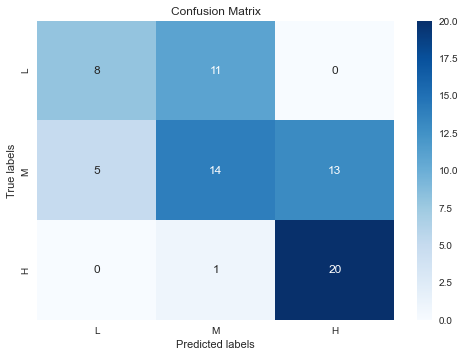

In [102]:
#confusion matrix
print("------------------------confusion matrix-----------------------------")
conf_matrix(y_test,y_pred)

C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


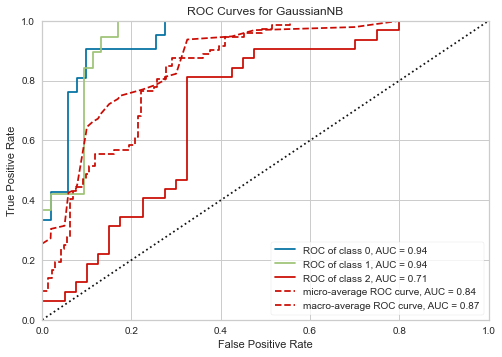

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=GaussianNB(var_smoothing=0.1))

In [103]:
#roc curve 

plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

In [105]:
#saving and analyzing wrong predictions 
print("------------------------saving result and analyzing wrong prediction-------")
save_analyze(y_pred,'Naive_Bayes_predictions')

------------------------saving result and analyzing wrong prediction-------
   gender  NationalITy PlaceofBirth       StageID GradeID SectionID    Topic  \
0       F       Jordan       Jordan    lowerlevel    G-02         A   French   
1       M           KW       KuwaIT  MiddleSchool    G-07         A     Math   
2       M           KW       KuwaIT    lowerlevel    G-02         B       IT   
6       M    Palestine       Jordan  MiddleSchool    G-07         B  Biology   
10      M           KW       KuwaIT  MiddleSchool    G-08         C  Spanish   
11      F       Jordan       KuwaIT  MiddleSchool    G-08         C  Spanish   
12      M       Jordan       Jordan    lowerlevel    G-02         A   French   
14      M          USA          USA  MiddleSchool    G-08         B     Math   
18      M       Jordan       Jordan    lowerlevel    G-02         B   Arabic   
20      M       Jordan  SaudiArabia    lowerlevel    G-02         B   Arabic   
21      M  SaudiArabia  SaudiArabia    lower

# algorithms with Normalized and one hot encoded data

In [106]:
training_data = pd.read_csv('Data/transformed/train_mms_ohe.csv')
training_data['Class'] = training_data['Class'].apply(lambda x: label_to_num[x])
X_train,y_train = training_data.iloc[:,:-1],training_data.iloc[:,-1:]

## Decision Tree

In [107]:
# Specify final ML model path
final_model_path = 'models/decision_tree.pkl'
final_model = load_pkl_model(final_model_path)
#prediction 
y_pred = predict(final_model,num_to_label,X_test_processed)

In [108]:
#classification report 
print("------------------------classification report------------------------")
class_report(y_test,y_pred)

------------------------classification report------------------------
              precision    recall  f1-score    support
H              0.653846  0.809524  0.723404  21.000000
L              0.708333  0.894737  0.790698  19.000000
M              0.727273  0.500000  0.592593  32.000000
accuracy       0.694444  0.694444  0.694444   0.694444
macro avg      0.696484  0.734754  0.702232  72.000000
weighted avg   0.700859  0.694444  0.683024  72.000000


------------------------confusion matrix-----------------------------


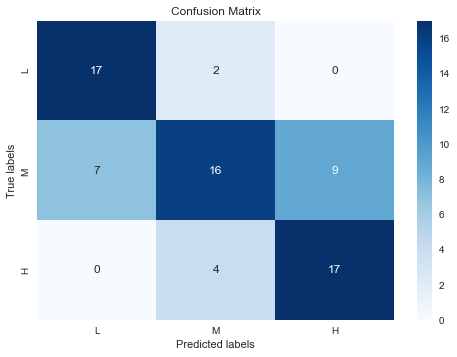

In [109]:
#confusion matrix
print("------------------------confusion matrix-----------------------------")
conf_matrix(y_test,y_pred)

C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


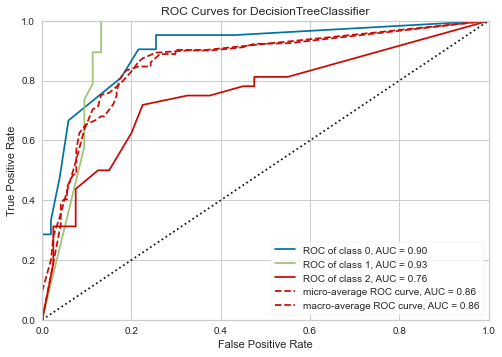

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=10, random_state=0))

In [110]:
#roc curve 

plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

In [111]:
#saving and analyzing wrong predictions 
print("------------------------saving result and analyzing wrong prediction-------")
save_analyze(y_pred,'decision_tree_predictions')

------------------------saving result and analyzing wrong prediction-------
   gender  NationalITy PlaceofBirth       StageID GradeID SectionID    Topic  \
0       F       Jordan       Jordan    lowerlevel    G-02         A   French   
1       M           KW       KuwaIT  MiddleSchool    G-07         A     Math   
2       M           KW       KuwaIT    lowerlevel    G-02         B       IT   
3       M       Jordan       Jordan  MiddleSchool    G-06         A  English   
8       M           KW       KuwaIT    lowerlevel    G-02         B   French   
16      F      lebanon      lebanon    lowerlevel    G-02         B   French   
18      M       Jordan       Jordan    lowerlevel    G-02         B   Arabic   
21      M  SaudiArabia  SaudiArabia    lowerlevel    G-02         B       IT   
23      F       Jordan       Jordan  MiddleSchool    G-06         A  English   
28      M           KW       KuwaIT    lowerlevel    G-02         B       IT   
29      M           KW       KuwaIT    lower

## Random Forest 

In [62]:
# Specify final ML model path
final_model_path = 'models/random_forest.pkl'
final_model = load_pkl_model(final_model_path)
#prediction 
y_pred = predict(final_model,num_to_label,X_test_processed)

In [63]:
#classification report 
print("------------------------classification report------------------------")
class_report(y_test,y_pred)

------------------------classification report------------------------
              precision    recall  f1-score    support
H              0.833333  0.714286  0.769231  21.000000
L              0.760000  1.000000  0.863636  19.000000
M              0.793103  0.718750  0.754098  32.000000
accuracy       0.791667  0.791667  0.791667   0.791667
macro avg      0.795479  0.811012  0.795655  72.000000
weighted avg   0.796102  0.791667  0.787418  72.000000


------------------------confusion matrix-----------------------------


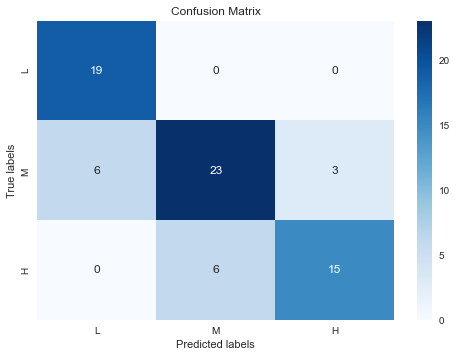

In [64]:
#confusion matrix
print("------------------------confusion matrix-----------------------------")
conf_matrix(y_test,y_pred)

C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


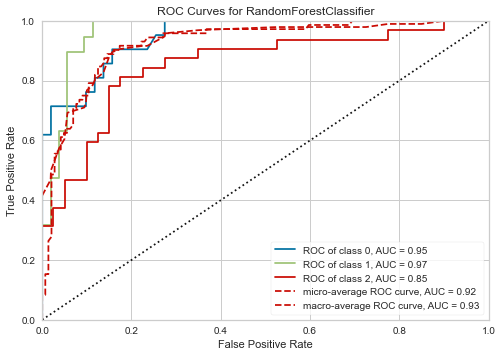

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=RandomForestClassifier(bootstrap=False, n_estimators=1200,
                                        random_state=0))

In [65]:
#roc curve 

plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

In [66]:
#saving and analyzing wrong predictions 
print("------------------------saving result and analyzing wrong prediction-------")
save_analyze(y_pred,'Random_forest_predictions')

------------------------saving result and analyzing wrong prediction-------
   gender  NationalITy PlaceofBirth       StageID GradeID SectionID    Topic  \
2       M           KW       KuwaIT    lowerlevel    G-02         B       IT   
3       M       Jordan       Jordan  MiddleSchool    G-06         A  English   
8       M           KW       KuwaIT    lowerlevel    G-02         B   French   
10      M           KW       KuwaIT  MiddleSchool    G-08         C  Spanish   
16      F      lebanon      lebanon    lowerlevel    G-02         B   French   
21      M  SaudiArabia  SaudiArabia    lowerlevel    G-02         B       IT   
23      F       Jordan       Jordan  MiddleSchool    G-06         A  English   
29      M           KW       KuwaIT    lowerlevel    G-04         A       IT   
30      F           KW       KuwaIT  MiddleSchool    G-06         A  Science   
46      M           KW       KuwaIT    lowerlevel    G-02         B   French   
51      F    Palestine       Jordan    lower

### logistic Regression

In [77]:
# Specify final ML model path
final_model_path = 'models/logistic_regression.pkl'
final_model = load_pkl_model(final_model_path)
#prediction 
y_pred = predict(final_model,num_to_label,X_test_processed)

In [78]:
#classification report 
print("------------------------classification report------------------------")
class_report(y_test,y_pred)

------------------------classification report------------------------
              precision    recall  f1-score    support
H              0.782609  0.857143  0.818182  21.000000
L              0.750000  0.947368  0.837209  19.000000
M              0.840000  0.656250  0.736842  32.000000
accuracy       0.791667  0.791667  0.791667   0.791667
macro avg      0.790870  0.820254  0.797411  72.000000
weighted avg   0.799511  0.791667  0.787052  72.000000


------------------------confusion matrix-----------------------------


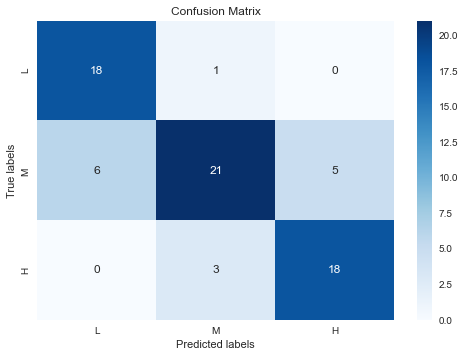

In [79]:
#confusion matrix
print("------------------------confusion matrix-----------------------------")
conf_matrix(y_test,y_pred)

C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


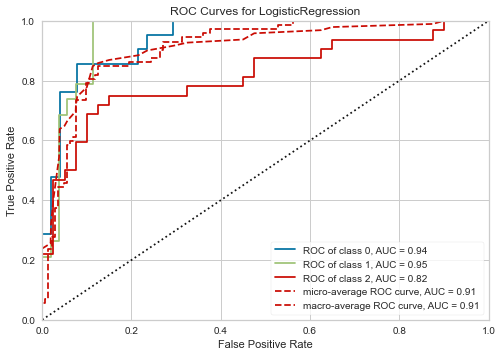

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=LogisticRegression(penalty='l1', random_state=0,
                                    solver='saga'))

In [80]:
#roc curve 

plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

In [81]:
#saving and analyzing wrong predictions 
print("------------------------saving result and analyzing wrong prediction-------")
save_analyze(y_pred,'logistic_reg_predictions')

------------------------saving result and analyzing wrong prediction-------
   gender  NationalITy PlaceofBirth       StageID GradeID SectionID  \
2       M           KW       KuwaIT    lowerlevel    G-02         B   
3       M       Jordan       Jordan  MiddleSchool    G-06         A   
10      M           KW       KuwaIT  MiddleSchool    G-08         C   
11      F       Jordan       KuwaIT  MiddleSchool    G-08         C   
18      M       Jordan       Jordan    lowerlevel    G-02         B   
21      M  SaudiArabia  SaudiArabia    lowerlevel    G-02         B   
23      F       Jordan       Jordan  MiddleSchool    G-06         A   
29      M           KW       KuwaIT    lowerlevel    G-04         A   
40      F       Jordan       Jordan  MiddleSchool    G-08         A   
46      M           KW       KuwaIT    lowerlevel    G-02         B   
52      M           KW       KuwaIT    lowerlevel    G-02         B   
54      F           KW       KuwaIT    lowerlevel    G-02         C   
6

### svm

In [93]:
# Specify final ML model path
final_model_path = 'models/svm.pkl'
final_model = load_pkl_model(final_model_path)
#prediction 
y_pred = predict(final_model,num_to_label,X_test_processed)

In [94]:
#classification report 
print("------------------------classification report------------------------")
class_report(y_test,y_pred)

------------------------classification report------------------------
              precision    recall  f1-score    support
H              0.708333  0.809524  0.755556  21.000000
L              0.761905  0.842105  0.800000  19.000000
M              0.740741  0.625000  0.677966  32.000000
accuracy       0.736111  0.736111  0.736111   0.736111
macro avg      0.736993  0.758876  0.744507  72.000000
weighted avg   0.736874  0.736111  0.732800  72.000000


------------------------confusion matrix-----------------------------


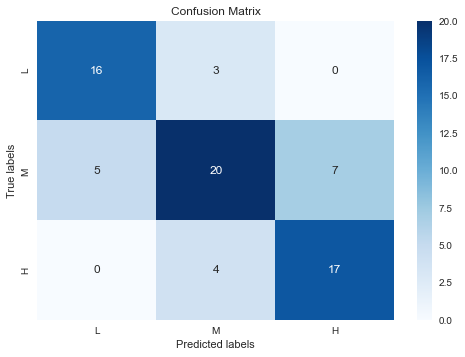

In [95]:
#confusion matrix
print("------------------------confusion matrix-----------------------------")
conf_matrix(y_test,y_pred)

C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


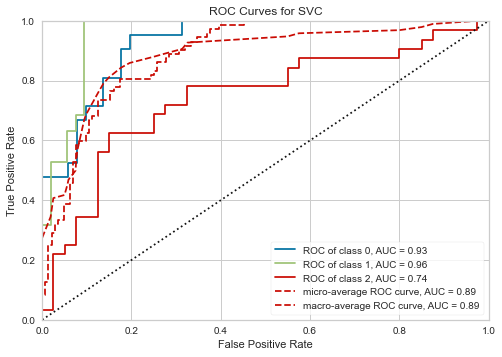

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=SVC(C=1, degree=1, random_state=0))

In [96]:
#roc curve 

plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

In [97]:
#saving and analyzing wrong predictions 
print("------------------------saving result and analyzing wrong prediction-------")
save_analyze(y_pred,'svm_predictions')

------------------------saving result and analyzing wrong prediction-------
   gender  NationalITy PlaceofBirth       StageID GradeID SectionID  \
0       F       Jordan       Jordan    lowerlevel    G-02         A   
1       M           KW       KuwaIT  MiddleSchool    G-07         A   
2       M           KW       KuwaIT    lowerlevel    G-02         B   
6       M    Palestine       Jordan  MiddleSchool    G-07         B   
10      M           KW       KuwaIT  MiddleSchool    G-08         C   
18      M       Jordan       Jordan    lowerlevel    G-02         B   
21      M  SaudiArabia  SaudiArabia    lowerlevel    G-02         B   
23      F       Jordan       Jordan  MiddleSchool    G-06         A   
29      M           KW       KuwaIT    lowerlevel    G-04         A   
30      F           KW       KuwaIT  MiddleSchool    G-06         A   
33      F       Jordan       Jordan    lowerlevel    G-05         A   
40      F       Jordan       Jordan  MiddleSchool    G-08         A   
4

### xgboost

In [87]:
# Specify final ML model path
final_model_path = 'models/xgboost.pkl'
final_model = load_pkl_model(final_model_path)
#prediction 
y_pred = predict(final_model,num_to_label,X_test_processed)

In [88]:
#classification report 
print("------------------------classification report------------------------")
class_report(y_test,y_pred)

------------------------classification report------------------------
              precision    recall  f1-score  support
H              0.714286  0.714286  0.714286    21.00
L              0.782609  0.947368  0.857143    19.00
M              0.750000  0.656250  0.700000    32.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.748965  0.772635  0.757143    72.00
weighted avg   0.748188  0.750000  0.745635    72.00


------------------------confusion matrix-----------------------------


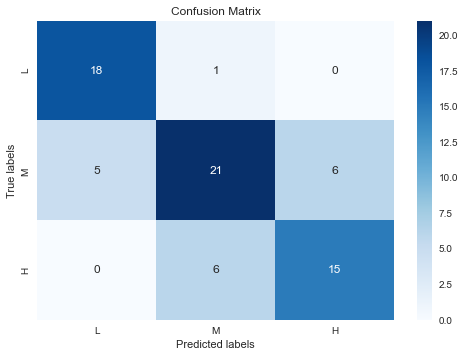

In [89]:
#confusion matrix
print("------------------------confusion matrix-----------------------------")
conf_matrix(y_test,y_pred)

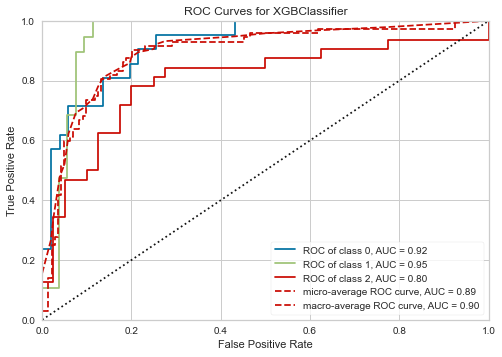

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='gini',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaf_nodes=4, max_leaves=0,
                               min_child_weight=1, min_samples_leaf=1,
                               min_samples_split=1, missing=nan,
  

In [90]:
#roc curve 

plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

In [92]:
#saving and analyzing wrong predictions 
print("------------------------saving result and analyzing wrong prediction-------")
save_analyze(y_pred,'xgboost_predictions')

------------------------saving result and analyzing wrong prediction-------
   gender  NationalITy PlaceofBirth       StageID GradeID SectionID    Topic  \
2       M           KW       KuwaIT    lowerlevel    G-02         B       IT   
3       M       Jordan       Jordan  MiddleSchool    G-06         A  English   
7       M       Jordan       Jordan    lowerlevel    G-02         A   French   
10      M           KW       KuwaIT  MiddleSchool    G-08         C  Spanish   
16      F      lebanon      lebanon    lowerlevel    G-02         B   French   
18      M       Jordan       Jordan    lowerlevel    G-02         B   Arabic   
21      M  SaudiArabia  SaudiArabia    lowerlevel    G-02         B       IT   
23      F       Jordan       Jordan  MiddleSchool    G-06         A  English   
30      F           KW       KuwaIT  MiddleSchool    G-06         A  Science   
38      M      lebanon      lebanon  MiddleSchool    G-08         C  Spanish   
46      M           KW       KuwaIT    lower

### Neural Network

In [98]:
# Specify final ML model path
final_model_path = 'models/clf.pkl'
final_model = load_pkl_model(final_model_path)
#prediction 
y_pred = predict(final_model,num_to_label,X_test_processed)

FileNotFoundError: [Errno 2] No such file or directory: 'models/clf.pkl'

In [88]:
#classification report 
print("------------------------classification report------------------------")
class_report(y_test,y_pred)

------------------------classification report------------------------
              precision    recall  f1-score  support
H              0.714286  0.714286  0.714286    21.00
L              0.782609  0.947368  0.857143    19.00
M              0.750000  0.656250  0.700000    32.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.748965  0.772635  0.757143    72.00
weighted avg   0.748188  0.750000  0.745635    72.00


------------------------confusion matrix-----------------------------


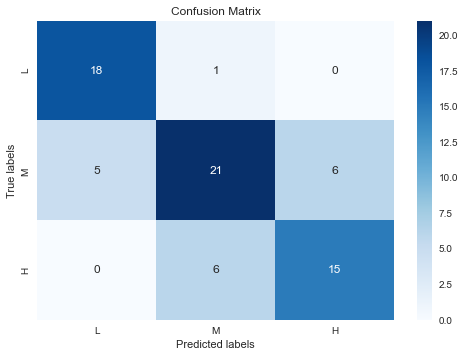

In [89]:
#confusion matrix
print("------------------------confusion matrix-----------------------------")
conf_matrix(y_test,y_pred)

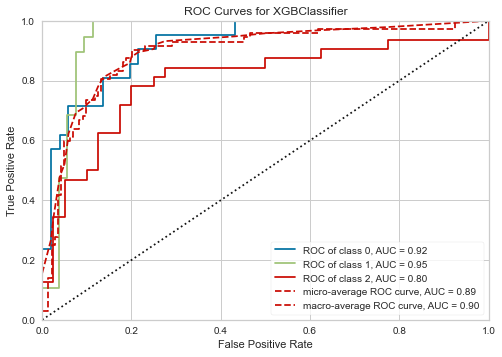

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='gini',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaf_nodes=4, max_leaves=0,
                               min_child_weight=1, min_samples_leaf=1,
                               min_samples_split=1, missing=nan,
  

In [90]:
#roc curve 

plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

In [92]:
#saving and analyzing wrong predictions 
print("------------------------saving result and analyzing wrong prediction-------")
save_analyze(y_pred,'xgboost_predictions')

------------------------saving result and analyzing wrong prediction-------
   gender  NationalITy PlaceofBirth       StageID GradeID SectionID    Topic  \
2       M           KW       KuwaIT    lowerlevel    G-02         B       IT   
3       M       Jordan       Jordan  MiddleSchool    G-06         A  English   
7       M       Jordan       Jordan    lowerlevel    G-02         A   French   
10      M           KW       KuwaIT  MiddleSchool    G-08         C  Spanish   
16      F      lebanon      lebanon    lowerlevel    G-02         B   French   
18      M       Jordan       Jordan    lowerlevel    G-02         B   Arabic   
21      M  SaudiArabia  SaudiArabia    lowerlevel    G-02         B       IT   
23      F       Jordan       Jordan  MiddleSchool    G-06         A  English   
30      F           KW       KuwaIT  MiddleSchool    G-06         A  Science   
38      M      lebanon      lebanon  MiddleSchool    G-08         C  Spanish   
46      M           KW       KuwaIT    lower

	Random forest 
    
    precision	recall	f1-score	support
H	0.833333	0.714286	0.769231	21.000000
L	0.760000	1.000000	0.863636	19.000000
M	0.793103	0.718750	0.754098	32.000000
accuracy	0.791667	0.791667	0.791667	0.791667
macro avg	0.795479	0.811012	0.795655	72.000000
weighted avg	0.796102	0.791667	0.787418	72.000000

svm 
	precision	recall	f1-score	support
H	0.708333	0.809524	0.755556	21.000000
L	0.761905	0.842105	0.800000	19.000000
M	0.740741	0.625000	0.677966	32.000000
accuracy	0.736111	0.736111	0.736111	0.736111
macro avg	0.736993	0.758876	0.744507	72.000000
weighted avg	0.736874	0.736111	0.732800	72.000000

array([[16,  3,  0],
       [ 5, 20,  7],
       [ 0,  4, 17]], dtype=int64)

xgboost

precision	recall	f1-score	support
H	0.714286	0.714286	0.714286	21.00
L	0.782609	0.947368	0.857143	19.00
M	0.750000	0.656250	0.700000	32.00
accuracy	0.750000	0.750000	0.750000	0.75
macro avg	0.748965	0.772635	0.757143	72.00
weighted avg	0.748188	0.750000	0.745635	72.00

array([[18,  1,  0],
       [ 5, 21,  6],
       [ 0,  6, 15]], dtype=int64)

# Final Conclution 